# Assignment 2: DenseNet with CIFAR10 Dataset by TensorFlow

In this assignment, you are required to implement DenseNet to classify images from the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) by using TensorFlow with Keras. DenseNet is very well-known and therefore it has been implemented and pre-trained by Keras. You are also required to load and test the pre-trained models, and compare them with your models.

First of all, read the DenseNet paper. DenseNet was originally proposed in 2016 by Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger in the following paper:
https://arxiv.org/abs/1608.06993

The process will be broken down into the following steps:
>
1. Answer a short question about DenseNet. (10 marks)
2. Load and visualize the data.
3. Implement your models. (30 marks)
4. Train and evaluate your models. (25 marks)
5. Load the pre-trained models from Keras and evaluate them. (15 marks)
6. Analysis your results. (20 marks)

---
## 1. Answer a short question (20 marks)

Now that you know what DenseNet is all about, let's compare it to VGG.
Both VGG and DenseNet papers describe several variations of their models that differ by their depth.
For example, VGG16 and VGG19, DenseNet-121 and DenseNet-169 are four examples from these papers.

Aside from difference in network depth, how is the architecture of DenseNet different from that of VGG? Please enter your answer in the next cell (approximately 100-200 words, both English and Chinese are acceptable).

VGG的结构非常简洁，整个网络都使用了同样大小的卷积核尺寸（3x3）和最大池化尺寸（2x2）。验证了通过不断加深网络结构可以提升性能。DenseNet提出了一个更激进的密集连接机制：即互相连接所有的层，具体来说就是每个层都会接受其前面所有层作为其额外的输入。由于密集连接方式，DenseNet提升了梯度的反向传播，使得网络更容易训练。

---
## 2. Load and visualize the data.

The data is directly loaded into memory.

In [25]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

num_classes = 10

# load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#y_train=y_train.reshape(-1)
#y_test=y_test.reshape(-1)
# input image dimensions
input_shape = x_train.shape[1:]

# normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print(len(x_train))

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
50000


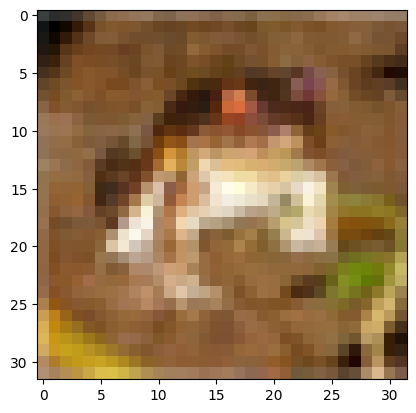

In [28]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

#### ---
## 3. Implement your models (30 marks)

In this task, you are required to implement DenseNet-41 and DenseNet-49 with compression and bottleneck as depicted in the original paper. DenseNet-41 and DenseNet-49 follow the architecture of DenseNet and remove several convolution layers for time efficiency. Specifically, DenseNet-41 and DenseNet-49 have a group of 4 Dense Block, each has a set of [3,6,6,3] and [4,6,8,4] mini-block including a 1x1 conv follow by a 3x3 conv. For more details, please refer to Table 1 in the original paper.

In [22]:
# implement the code of your DenseNet-41 model here.
import tensorflow as tf
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels):
        super(ConvBlock, self).__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=4*num_channels, kernel_size=1)##bottleneck
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(
            filters=num_channels, kernel_size=(3, 3), padding='same')

        self.listLayers = [self.bn1, self.relu1, self.conv1,self.bn2, self.relu2, self.conv2]

    def call(self, x):
        y = x
        for layer in self.listLayers.layers:
            y = layer(y)
        y = tf.keras.layers.concatenate([x,y], axis=-1)
        return y


class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        self.listLayers = []
        for _ in range(num_convs):
            self.listLayers.append(ConvBlock(num_channels))

    def call(self, x):
        for layer in self.listLayers.layers:
            x = layer(x)
        return x

class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(TransitionBlock, self).__init__(**kwargs)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(num_channels, kernel_size=1)
        self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=2, strides=2)

    def call(self, x):
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.conv(x)
        return self.avg_pool(x)
    
def block_1():
    return tf.keras.Sequential([
       tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.ReLU(),
       tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

def block_2():
    net = block_1()
    # num_channels为当前的通道数
    num_channels, growth_rate = 64, 32
    num_convs_in_dense_blocks = [3, 6, 6, 3]

    for i, num_convs in enumerate(num_convs_in_dense_blocks):
        net.add(DenseBlock(num_convs, growth_rate))
        # 上一个稠密块的输出通道数
        num_channels += num_convs * growth_rate
        # 在稠密块之间添加一个转换层，使通道数量减半
        if i != len(num_convs_in_dense_blocks) - 1:
            num_channels //= 2  ##compression
            net.add(TransitionBlock(num_channels))
    return net

def net1():
    net = block_2()
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.ReLU())
    net.add(tf.keras.layers.GlobalAvgPool2D())
    net.add(tf.keras.layers.Flatten())
    net.add(tf.keras.layers.Dense(10))
    return net




In [17]:
# implement the code of your DenseNet-49 model here.
import tensorflow as tf
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels):
        super(ConvBlock, self).__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=4*num_channels, kernel_size=1)##bottleneck
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(
            filters=num_channels, kernel_size=(3, 3), padding='same')

        self.listLayers = [self.bn1, self.relu1, self.conv1,self.bn2, self.relu2, self.conv2]

    def call(self, x):
        y = x
        for layer in self.listLayers.layers:
            y = layer(y)
        y = tf.keras.layers.concatenate([x,y], axis=-1)
        return y


class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        self.listLayers = []
        for _ in range(num_convs):
            self.listLayers.append(ConvBlock(num_channels))

    def call(self, x):
        for layer in self.listLayers.layers:
            x = layer(x)
        return x

class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(TransitionBlock, self).__init__(**kwargs)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(num_channels, kernel_size=1)
        self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=2, strides=2)

    def call(self, x):
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.conv(x)
        return self.avg_pool(x)
    
def block_1():
    return tf.keras.Sequential([
       tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.ReLU(),
       tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

def block_2():
    net = block_1()
    # num_channels为当前的通道数
    num_channels, growth_rate = 64, 32
    num_convs_in_dense_blocks = [4, 6, 8, 4]

    for i, num_convs in enumerate(num_convs_in_dense_blocks):
        net.add(DenseBlock(num_convs, growth_rate))
        # 上一个稠密块的输出通道数
        num_channels += num_convs * growth_rate
        # 在稠密块之间添加一个转换层，使通道数量减半
        if i != len(num_convs_in_dense_blocks) - 1:
            num_channels //= 2  ##compression
            net.add(TransitionBlock(num_channels))
    return net

def net2():
    net = block_2()
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.ReLU())
    net.add(tf.keras.layers.GlobalAvgPool2D())
    net.add(tf.keras.layers.Flatten())
    net.add(tf.keras.layers.Dense(10))
    return net




---
## 4. Train and evaluate your models. (25 marks)

### 4.1 Train your models. (20 marks)

In [23]:
# implement your code here.
# DenseNet-41

batch_size = 500
epochs = 20
net1=net1()

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
net1.compile(optimizer, tf.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
history = net1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
acc = history.history['accuracy']
loss = history.history['loss']
print("training accuracy:{}, training loss:{}".format(acc[-1], loss[-1]))



Epoch 1/20
100/100 [==============================] - 132s 1s/step - loss: 1.5604 - accuracy: 0.4319
Epoch 2/20
100/100 [==============================] - 128s 1s/step - loss: 1.1789 - accuracy: 0.5723
Epoch 3/20
100/100 [==============================] - 120s 1s/step - loss: 0.9631 - accuracy: 0.6566
Epoch 4/20
100/100 [==============================] - 120s 1s/step - loss: 0.8210 - accuracy: 0.7083
Epoch 5/20
100/100 [==============================] - 121s 1s/step - loss: 0.7130 - accuracy: 0.7484
Epoch 6/20
100/100 [==============================] - 123s 1s/step - loss: 0.6257 - accuracy: 0.7793
Epoch 7/20
100/100 [==============================] - 130s 1s/step - loss: 0.5594 - accuracy: 0.8023
Epoch 8/20
100/100 [==============================] - 126s 1s/step - loss: 0.4896 - accuracy: 0.8267
Epoch 9/20
100/100 [==============================] - 131s 1s/step - loss: 0.4369 - accuracy: 0.8455
Epoch 10/20
100/100 [==============================] - 131s 1s/step - loss: 0.3768 - accura

In [18]:
# DenseNet-49
batch_size = 500
epochs = 20
net2=net2()

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
net2.compile(optimizer, tf.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
history = net2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
acc = history.history['accuracy']
loss = history.history['loss']
print("training accuracy:{}, training loss:{}".format(acc[-1], loss[-1]))

Epoch 1/20
100/100 [==============================] - 150s 1s/step - loss: 1.5446 - accuracy: 0.4368
Epoch 2/20
100/100 [==============================] - 145s 1s/step - loss: 1.1712 - accuracy: 0.5784
Epoch 3/20
100/100 [==============================] - 143s 1s/step - loss: 0.9419 - accuracy: 0.6658
Epoch 4/20
100/100 [==============================] - 141s 1s/step - loss: 0.7965 - accuracy: 0.7165
Epoch 5/20
100/100 [==============================] - 143s 1s/step - loss: 0.6780 - accuracy: 0.7612
Epoch 6/20
100/100 [==============================] - 142s 1s/step - loss: 0.5995 - accuracy: 0.7894
Epoch 7/20
100/100 [==============================] - 141s 1s/step - loss: 0.5167 - accuracy: 0.8177
Epoch 8/20
100/100 [==============================] - 142s 1s/step - loss: 0.4596 - accuracy: 0.8372
Epoch 9/20
100/100 [==============================] - 141s 1s/step - loss: 0.3872 - accuracy: 0.8625
Epoch 10/20
100/100 [==============================] - 143s 1s/step - loss: 0.3522 - accura

### 4.2 Test your models. (5 marks)

In [24]:
# implement your code here.
# DenseNet-41
test_loss, test_acc = net1.evaluate(x_test, y_test)
print("test loss:{}, test accuracy:{}".format(test_loss, test_acc))

313/313 [==============================] - 23s 63ms/step - loss: 1.7360 - accuracy: 0.6783
test loss:1.7360326051712036, test accuracy:0.6783000230789185


In [19]:
# implement your code here.
# DenseNet-49
test_loss, test_acc = net2.evaluate(x_test, y_test)
print("test loss:{}, test accuracy:{}".format(test_loss, test_acc))

313/313 [==============================] - 13s 36ms/step - loss: 1.4860 - accuracy: 0.7016
test loss:1.485963225364685, test accuracy:0.7016000151634216


---
## 5. Load the pre-trained models from Keras and evaluate them. (15 marks)

Use the pre-trained DenseNet-121 model from keras and fine-tune them by adding a few fc layers at the end. You should set the parameter weights='imagenet', rather than None, to use the pretrained weights.

In [26]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras import Sequential,layers
# implement your code here.

batch_size = 500
epochs = 30
net3 = Sequential()
net3.add(DenseNet121(include_top=False,input_shape=(32,32,3),pooling='avg', weights='imagenet'))
net3.add(layers.Dense(10, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
net3.compile(optimizer, tf.losses.categorical_crossentropy, metrics=["accuracy"])
history = net3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
acc = history.history['accuracy']
loss = history.history['loss']
print("training accuracy:{}, training loss:{}".format(acc[-1], loss[-1]))


Epoch 1/30
100/100 [==============================] - 331s 3s/step - loss: 1.8583 - accuracy: 0.3616
Epoch 2/30
100/100 [==============================] - 320s 3s/step - loss: 1.7315 - accuracy: 0.3838
Epoch 3/30
100/100 [==============================] - 321s 3s/step - loss: 1.7803 - accuracy: 0.3634
Epoch 4/30
100/100 [==============================] - 322s 3s/step - loss: 1.6139 - accuracy: 0.4224
Epoch 5/30
100/100 [==============================] - 321s 3s/step - loss: 1.4238 - accuracy: 0.4863
Epoch 6/30
100/100 [==============================] - 322s 3s/step - loss: 1.3094 - accuracy: 0.5338
Epoch 7/30
100/100 [==============================] - 321s 3s/step - loss: 1.4335 - accuracy: 0.5036
Epoch 8/30
100/100 [==============================] - 322s 3s/step - loss: 1.2659 - accuracy: 0.5576
Epoch 9/30
100/100 [==============================] - 322s 3s/step - loss: 1.1161 - accuracy: 0.6113
Epoch 10/30
100/100 [==============================] - 322s 3s/step - loss: 1.1528 - accura

In [28]:

test_loss, test_acc = net3.evaluate(x_test, y_test)
print("test loss:{}, test accuracy:{}".format(test_loss, test_acc))


313/313 [==============================] - 22s 70ms/step - loss: 1.0136 - accuracy: 0.6906
test loss:1.013573169708252, test accuracy:0.6905999779701233


---
## 6. Analysis your results. (20 marks)
Compare the performance of your models with the following analysis. Both English and Chinese answers are acceptable.
1. Is your implementation of DenseNet-49 better than DenseNet-41? If yes, how is the improvement? If no, try to figure the reason out based on your experiments. (10 marks)

Answer:
DenseNet-49比DenseNet-41的效果要好，DenseNet-49在测试集上的精度要高于DenseNet-41在测试集上的精度，DenseNet-49在测试集上的损失要小于DenseNet-41在测试集上的损失。

2. Compare the results of your implementations with the pre-trained DenseNet-121 models from Keras. (10 marks)

Answer:使用预训练的DenseNet-121的模型，训练的精度要比DenseNet-41和DenseNet-49的精度要小，测试精度和DenseNet-41和DenseNet-49的精度相差不大。
